# Similar LMC and SMC
LMC and SMC have different samples just because...they're different. So I want to limit my sample in the LMC to be as similar to the SMC as I can. To do this I'm just going to use something similar to the ISO_fit function but with LMC and SMC as the inputs.

In [83]:
from astropy.table import Table, Column
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G, sigma_sb, c
import scipy.stats

import warnings
warnings.filterwarnings('ignore')

In [145]:
%run Binary_Data_Clean2.py
Tables = Binary_Data_Clean2('/home/cody/Binary Search/2nd_Data_Set/mc_rgb_nocuts.fits','/home/cody/Binary Search/2nd_Data_Set/allVisit-t9-l31c-58247.mc.fits',
                          '/home/cody/Binary Search/parsec_decamsdss_all.fits.gz')
AllAvg, AllVis, ISO = Tables.get_data()
AllVis = Tables.cuts(AllVis)
AllAvg = Tables.nvisits_cut(AllAvg,5)


In [146]:
AAS_RG = Tables.rg_cut(AllAvg)

In [147]:
AAS_RG_ISO = Tables.iso_fit(AAS_RG, ISO)
AAS_RV = Tables.rv_table_add(AAS_RG_ISO, AllVis)
AllAvg_LMC_5 = Tables.mc_cut(AAS_RV, 'L')
AllAvg_SMC_5 = Tables.mc_cut(AAS_RV, 'S')

In [148]:
def same_dat(table1, table2,  temp_lim = 250, logg_lim = 0.2, feh_lim = 0.2, snr_lim = 100):
    """
    Makes the data between two tables similar with in some limit
    
    Inputs
    ---------
    table1:  Should be the larger table that we want cut down
    table2:  Should be the smaller table that we want to compare the larger table to
    limit:   Tollerence that we want to compare the data to.
    
    Output
    ----------
    table1:  Modified table1 only keeping data points that are close to table2
    """
    # For each row in all_average_data, find isochrone rows that have similar
    # values, and make a list of all of those entries.
    dtype_list = []
    table1_foo = Table(table1, copy = True)
    table2_foo = Table(table2, copy = True)
    for n in range(len(table1_foo.dtype)):
        dtype_list.append(table1_foo.dtype[n])
    
    table3_foo = Table(names = table1_foo.colnames, dtype = dtype_list)
    rr = []
    for j in range(len(table2)):
        gd, = np.where((np.abs(table1_foo['TEFF'] - table2_foo['TEFF'][j]) < temp_lim) &
                       (np.abs(table1_foo['LOGG'] - table2_foo['LOGG'][j]) < logg_lim) &
                       (np.abs(table1_foo['FE_H'] - table2_foo['FE_H'][j]) < feh_lim ) #&
                       #(np.abs(table1_foo['VERR'] - table2['VERR'][j]) < snr_lim )
                      )
                       
        #print(gd, type(gd))
        if len(gd) == 1:
            table3_foo.add_row(table1_foo[gd[0]])
            table1_foo.remove_row(gd[0])
            #print(len(table1_foo))
        elif len(gd) > 2:
            rand = np.random.randint(0,len(gd))
            table3_foo.add_row(table1_foo[gd[rand]])
            table1_foo.remove_row(gd[rand])
        else:
            rr.append(j)
    
    table2_foo.remove_rows(rr)

    return table3_foo, table2_foo

#### Now when I run same_dat I should end up with tables for the LMC and SMC that have similar TEFF, LOGG, and FE_H properties

In [149]:
AllAvg_LMC, AllAvg_SMC = same_dat(AllAvg_LMC_5, AllAvg_SMC_5)

In [150]:
len(AllAvg_LMC), len(AllAvg_SMC)

(213, 213)

In [151]:
%run Table_Convert.py
AllAvg_SMC=Table_Convert(AllAvg_SMC)
AllAvg_LMC=Table_Convert(AllAvg_LMC)

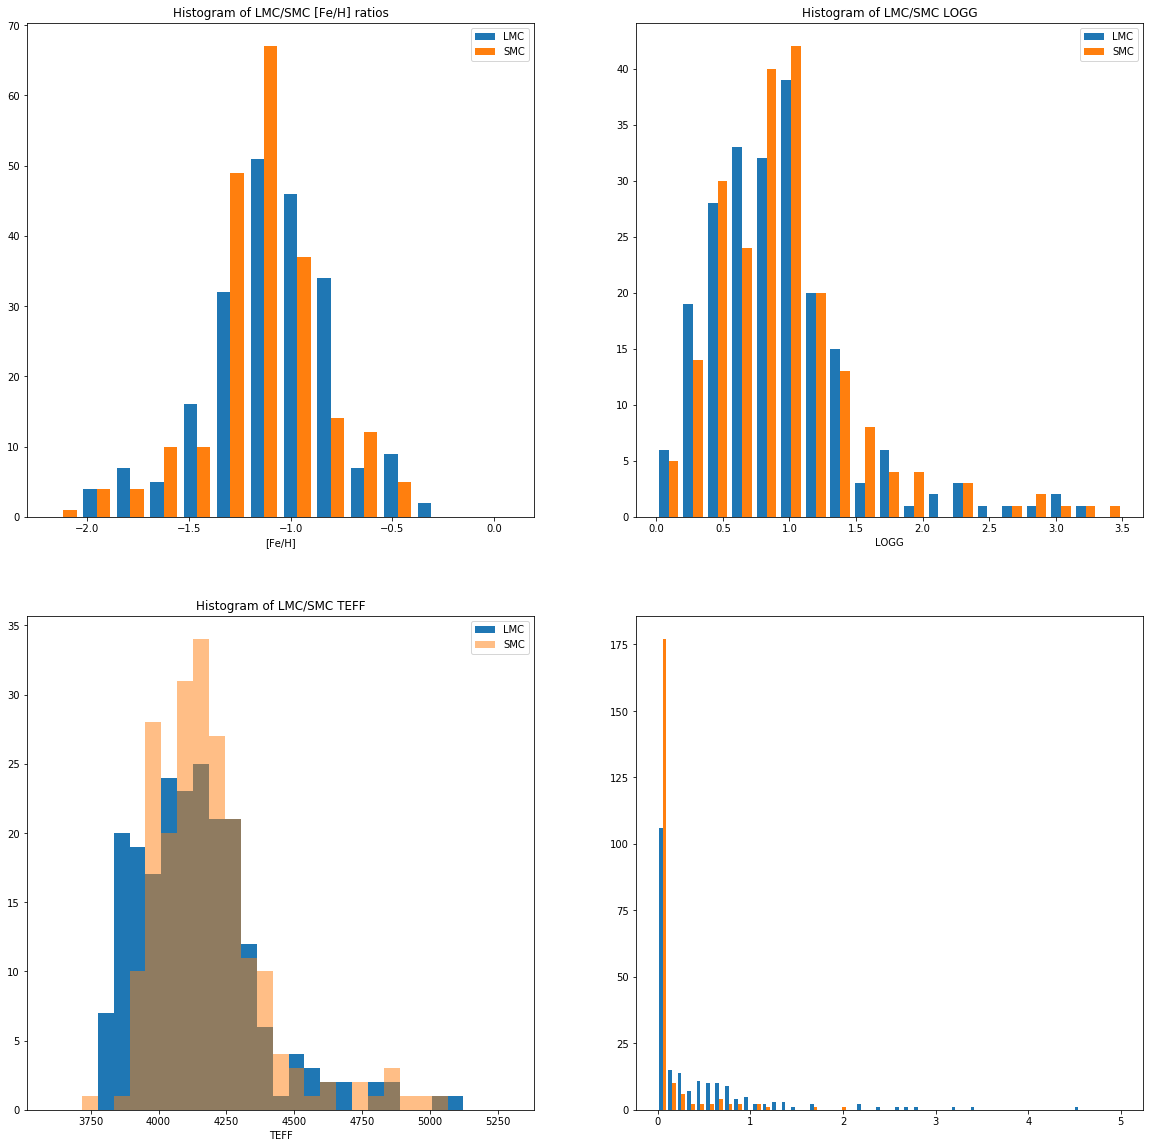

In [152]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize = (20,20))
ax1.hist([AllAvg_LMC['FE_H'], AllAvg_SMC['FE_H']],
         label = ['LMC', 'SMC'],
         bins = np.linspace(-2.2,.1,15))

ax2.hist([AllAvg_LMC['LOGG'], AllAvg_SMC['LOGG']],
          label = ['LMC','SMC'],
          bins = np.linspace(0,3.5,20), align = 'mid')

ax3.hist(AllAvg_LMC['TEFF'], color = 'C0', bins = np.linspace(3600,5300,30), label = 'LMC')
ax3.hist(AllAvg_SMC['TEFF'], color = 'C1', alpha = 0.5,bins = np.linspace(3600,5300,30),label = 'SMC')

ax4.hist([AllAvg_LMC['VERR'], AllAvg_SMC['VERR']],  label = ['LMC', 'SMC'],align = 'mid', bins = np.linspace(0,5))


ax1.set_title('Histogram of LMC/SMC [Fe/H] ratios')
ax1.set_xlabel('[Fe/H]')
ax1.legend()
ax2.set_title('Histogram of LMC/SMC LOGG')
ax2.set_xlabel('LOGG')
ax2.legend()
ax3.set_title('Histogram of LMC/SMC TEFF')
ax3.set_xlabel('TEFF')
ax3.legend()
plt.show()

([array([ 3., 14., 34., 46., 29., 29., 25., 13., 12.,  8.]),
  array([ 0., 11., 45., 76., 52., 25.,  3.,  1.,  0.,  0.])],
 array([ 13.15540028,  26.36753511,  39.57966995,  52.79180479,
         66.00393963,  79.21607447,  92.4282093 , 105.64034414,
        118.85247898, 132.06461382, 145.27674866]),
 <a list of 2 Lists of Patches objects>)

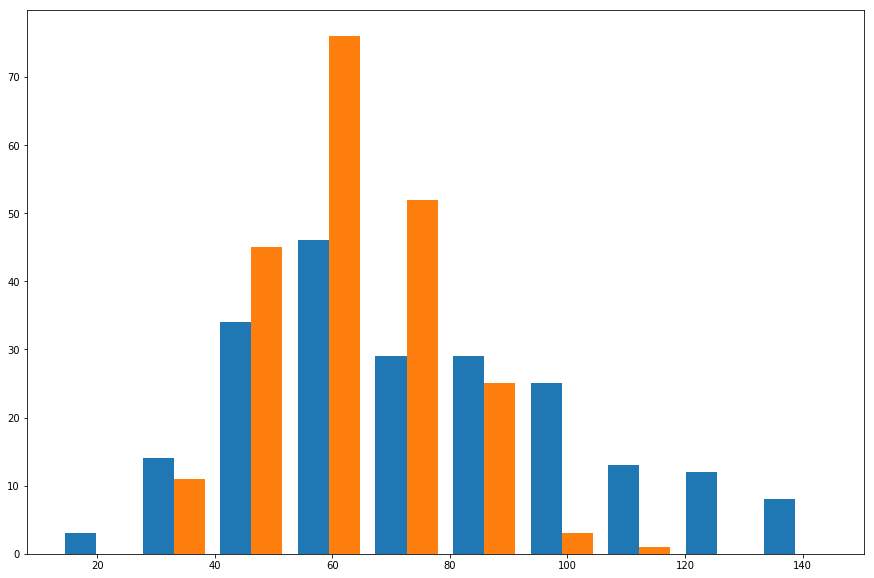

In [153]:
plt.figure(figsize = (15,10))
plt.hist([AllAvg_LMC['SNR'], AllAvg_SMC['SNR']],
         label = ['LMC', 'SMC'],
        )

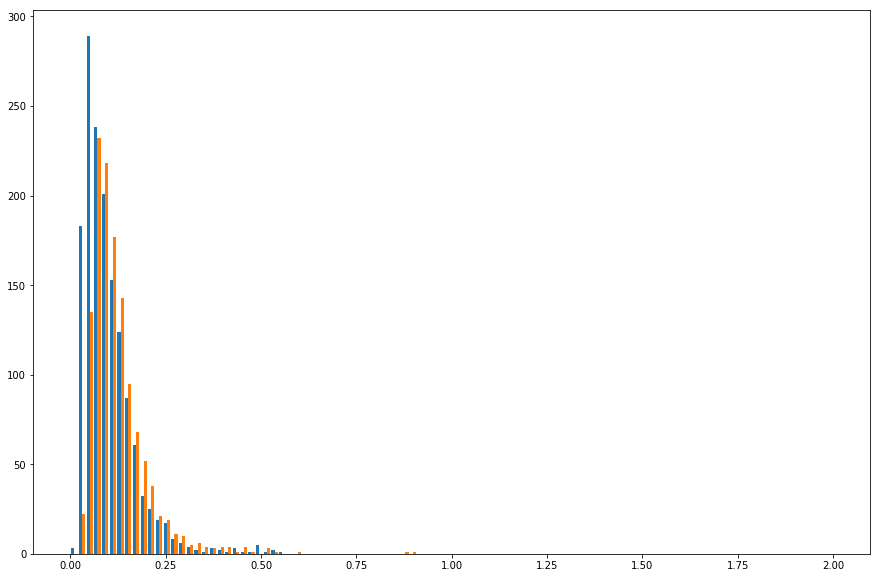

(1473, 1282)

In [156]:
err_list_lmc = [x for star in AllAvg_LMC['RADIAL_ERR'] for x in star]
err_list_smc = [x for star in AllAvg_SMC['RADIAL_ERR'] for x in star]

plt.figure(figsize = (15,10))
plt.hist([err_list_lmc, err_list_smc], bins = np.linspace(0,2,100))
plt.show()
len(err_list_lmc), len(err_list_smc)

In [157]:
AllAvg_LMC

RADIALV,RADIAL_ERR,RADIAL_DATE,APSTAR_ID,TARGET_ID,ASPCAP_ID,FILE,APOGEE_ID,TELESCOPE,LOCATION_ID,FIELD,J,J_ERR,H,H_ERR,K,K_ERR,RA,DEC,GLON,GLAT,APOGEE_TARGET1,APOGEE_TARGET2,APOGEE_TARGET3,APOGEE2_TARGET1,APOGEE2_TARGET2,APOGEE2_TARGET3,TARGFLAGS,SURVEY,NINST [3],NVISITS,COMBTYPE,COMMISS,SNR,STARFLAG,STARFLAGS,ANDFLAG,ANDFLAGS,VHELIO_AVG,VSCATTER,VERR,VERR_MED,OBSVHELIO_AVG,OBSVSCATTER,OBSVERR,OBSVERR_MED,SYNTHVHELIO_AVG,SYNTHVSCATTER,SYNTHVERR,SYNTHVERR_MED,RV_TEFF,RV_LOGG,RV_FEH,RV_ALPHA,RV_CARB,RV_CCFWHM,RV_AUTOFWHM,SYNTHSCATTER,STABLERV_CHI2 [2],STABLERV_RCHI2 [2],CHI2_THRESHOLD [2],STABLERV_CHI2_PROB [2],MEANFIB,SIGFIB,SNREV,APSTAR_VERSION,ASPCAP_VERSION,RESULTS_VERSION,EXTRATARG,MIN_H,MAX_H,MIN_JK,MAX_JK,PARAM [9],FPARAM [9],"PARAM_COV [9,9]","FPARAM_COV [9,9]",TEFF,TEFF_ERR,LOGG,LOGG_ERR,VMICRO,VMACRO,VSINI,M_H,M_H_ERR,ALPHA_M,ALPHA_M_ERR,ASPCAP_CHI2,ASPCAP_CLASS,ASPCAPFLAG,ASPCAPFLAGS,PARAMFLAG [9],FELEM [26],FELEM_ERR [26],X_H [26],X_H_ERR [26],X_M [26],X_M_ERR [26],C_FE,CI_FE,N_FE,O_FE,NA_FE,MG_FE,AL_FE,SI_FE,P_FE,S_FE,K_FE,CA_FE,TI_FE,TIII_FE,V_FE,CR_FE,MN_FE,FE_H,CO_FE,NI_FE,CU_FE,GE_FE,RB_FE,Y_FE,ND_FE,C_FE_ERR,CI_FE_ERR,N_FE_ERR,O_FE_ERR,NA_FE_ERR,MG_FE_ERR,AL_FE_ERR,SI_FE_ERR,P_FE_ERR,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,FE_H_ERR,CO_FE_ERR,NI_FE_ERR,CU_FE_ERR,GE_FE_ERR,RB_FE_ERR,Y_FE_ERR,ND_FE_ERR,C_FE_FLAG,CI_FE_FLAG,N_FE_FLAG,O_FE_FLAG,NA_FE_FLAG,MG_FE_FLAG,AL_FE_FLAG,SI_FE_FLAG,P_FE_FLAG,S_FE_FLAG,K_FE_FLAG,CA_FE_FLAG,TI_FE_FLAG,TIII_FE_FLAG,V_FE_FLAG,CR_FE_FLAG,MN_FE_FLAG,FE_H_FLAG,CO_FE_FLAG,NI_FE_FLAG,CU_FE_FLAG,GE_FE_FLAG,RB_FE_FLAG,Y_FE_FLAG,ND_FE_FLAG,ELEM_CHI2 [26],ELEMFLAG [26],REDUCTION_ID,SRC_H,WASH_M,WASH_M_ERR,WASH_T2,WASH_T2_ERR,DDO51,DDO51_ERR,IRAC_3_6,IRAC_3_6_ERR,IRAC_4_5,IRAC_4_5_ERR,IRAC_5_8,IRAC_5_8_ERR,IRAC_8_0,IRAC_8_0_ERR,WISE_4_5,WISE_4_5_ERR,TARG_4_5,TARG_4_5_ERR,AK_TARG,AK_TARG_METHOD,AK_WISE,SFD_EBV,WASH_DDO51_GIANT_FLAG,WASH_DDO51_STAR_FLAG,PMRA,PMDEC,PM_SRC,ALL_VISITS,VISITS,ALL_VISIT_PK [50],VISIT_PK [50],"FPARAM_CLASS [23,9]",CHI2_CLASS [23],LMCPA,LMCRAD,SMCPA,SMCRAD,MLON,MLAT,M,MERR,DDO51ERR,T2,T2ERR,DELTA_VHELIO,DELTA_PMRA,DELTA_PMDEC,DELTA_FEH,DELTA_ALPHA,TARGET_TYPE,TARGET_NAME,PRIORITY,GAIA_SOURCEID,GAIA_PARALLAX,GAIA_PARALLAX_ERROR,GAIA_DIST05,GAIA_DIST_MODE,GAIA_DIST95,GAIA_PMRA,GAIA_PMRA_ERROR,GAIA_PMDEC,GAIA_PMDEC_ERROR,GAIA_GMAG,GAIA_BPMAG,GAIA_RPMAG,GAIA_PML,GAIA_PMB,GAIA_PMML,GAIA_PMMB,ISO_MEANM,ISO_MEDIANM,ISO_STDM,ISO_MEANL,ISO_MEDIANL,ISO_STDL,ISO_MEANR
object,object,object,str47,str36,str59,str38,str18,str8,int32,str5,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,str192,str35,int32,int32,int32,int16,float32,int32,str165,int32,str58,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,str4,str7,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str5,int32,str189,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,float32,int32,str23,str14,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str17,float32,float32,int16,int16,float32,float3

In [158]:
%run Binary_Fraction.py
thing_LMC = Binary_Fraction(AllAvg_LMC)
thing_SMC = Binary_Fraction(AllAvg_SMC)
#real_data = [real_data_detection_LMC_5, binary_bool_LMC_5, LMC_binary_detection_5, rd_err_LMC]
real_data_LMC = thing_LMC.Real_Data_Fraction()
real_data_SMC = thing_SMC.Real_Data_Fraction()

#synthetic_rates = [p_value_result_LMC, binary_result_LMC,  detection_rate_LMC, errors_LMC]
synthetic_rates_LMC = thing_LMC.synthetic_detection_rate(200,'L',True,False,[0,1],30)
synthetic_rates_SMC = thing_SMC.synthetic_detection_rate(200,'L',True,False,[0,1],30)

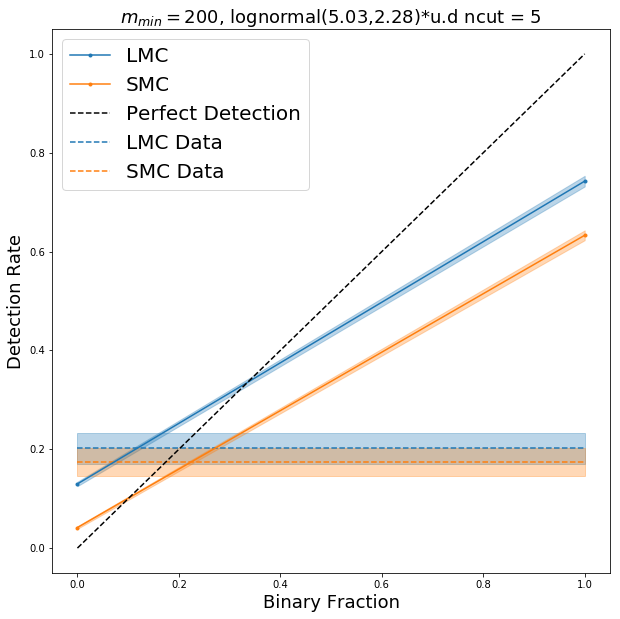

In [159]:
plt.figure(figsize = (10,10))
b_frac = [0,1]
plt.plot(b_frac, synthetic_rates_LMC[2],'.-', color = 'C0', label = 'LMC')
plt.hlines(real_data_LMC[2], 0 ,1, color = 'C0', linestyles='dashed', label = 'LMC Data')
plt.fill_between([0,1],
                 [synthetic_rates_LMC[3][0][1], synthetic_rates_LMC[3][1][1]],
                 [synthetic_rates_LMC[3][0][0], synthetic_rates_LMC[3][1][0]],
                 alpha = 0.3, color = 'C0')
plt.fill_between([0,1], real_data_LMC[3][0][0], real_data_LMC[3][0][1], alpha = 0.3, color = 'C0')

plt.plot(b_frac, synthetic_rates_SMC[2],'.-', color = 'C1', label = 'SMC')
plt.hlines(real_data_SMC[2], 0 ,1, color = 'C1', linestyles='dashed', label = 'SMC Data')
plt.fill_between([0,1],
                 [synthetic_rates_SMC[3][0][1], synthetic_rates_SMC[3][1][1]],
                 [synthetic_rates_SMC[3][0][0], synthetic_rates_SMC[3][1][0]],
                 alpha = 0.3, color = 'C1')
plt.fill_between([0,1], real_data_SMC[3][0][0], real_data_SMC[3][0][1], alpha = 0.3, color = 'C1')

plt.plot([0,1],[0,1],'--', color = 'black',label = 'Perfect Detection')
plt.xlabel('Binary Fraction', size = 18)
plt.ylabel('Detection Rate', size = 18)
plt.title('$m_{min} = 200$, lognormal(5.03,2.28)*u.d ncut = 5', size = 18)
plt.legend(prop = {'size': 20})
plt.show()

# VERR
I'm thinking the main reason there's a difference is because of the VERR difference between the two data sets. When I'm making the synthetic RV data I'm using VERR as my gaussian noise

    solo_RV = np.random.normal(self.AAS_TABLE['VHELIO_AVG'][N], self.AAS_TABLE['VERR'][N] ,size = len(self.AAS_TABLE["RADIALV"][N]))
    
So i'm going to restart the Kernel and rerun same_dat but cut out any VERR rows that are too large

In [131]:
def same_dat(table1, table2,  temp_lim = 250, logg_lim = 0.2, feh_lim = 0.2, verr_lim = 0.05):
    """
    Makes the data between two tables similar with in some limit
    
    Inputs
    ---------
    table1:  Should be the larger table that we want cut down
    table2:  Should be the smaller table that we want to compare the larger table to
    limit:   Tollerence that we want to compare the data to.
    
    Output
    ----------
    table1:  Modified table1 only keeping data points that are close to table2
    """
    # For each row in all_average_data, find isochrone rows that have similar
    # values, and make a list of all of those entries.
    dtype_list = []
    table1_foo = Table(table1, copy = True)
    table2_foo = Table(table2, copy = True)
    for n in range(len(table1_foo.dtype)):
        dtype_list.append(table1_foo.dtype[n])
    
    table3_foo = Table(names = table1_foo.colnames, dtype = dtype_list)
    
    rr = []
    for j in range(len(table2_foo)):
        gd, = np.where((np.abs(table1_foo['TEFF'] - table2_foo['TEFF'][j]) < temp_lim) &
                       (np.abs(table1_foo['LOGG'] - table2_foo['LOGG'][j]) < logg_lim) &
                       (np.abs(table1_foo['FE_H'] - table2_foo['FE_H'][j]) < feh_lim ) &
                       (np.abs(table1_foo['VERR'] - table2_foo['VERR'][j]) < verr_lim )
                      )
                       
        #print(gd, type(gd))
        if len(gd) == 1:
            table3_foo.add_row(table1_foo[gd[0]])
            table1_foo.remove_row(gd[0])
            #print(len(table1_foo))
        elif len(gd) > 2:
            rand = np.random.randint(0,len(gd))
            table3_foo.add_row(table1_foo[gd[rand]])
            table1_foo.remove_row(gd[rand])
        else:
            rr.append(j)
    table2_foo.remove_rows(rr)
    
    return table3_foo, table2_foo

In [132]:
AllAvg_LMC, AllAvg_SMC = same_dat(AllAvg_LMC_5, AllAvg_SMC_5)
print(len(AllAvg_LMC), len(AllAvg_SMC))

%run Table_Convert.py
AllAvg_SMC=Table_Convert(AllAvg_SMC)
AllAvg_LMC=Table_Convert(AllAvg_LMC)

143 143


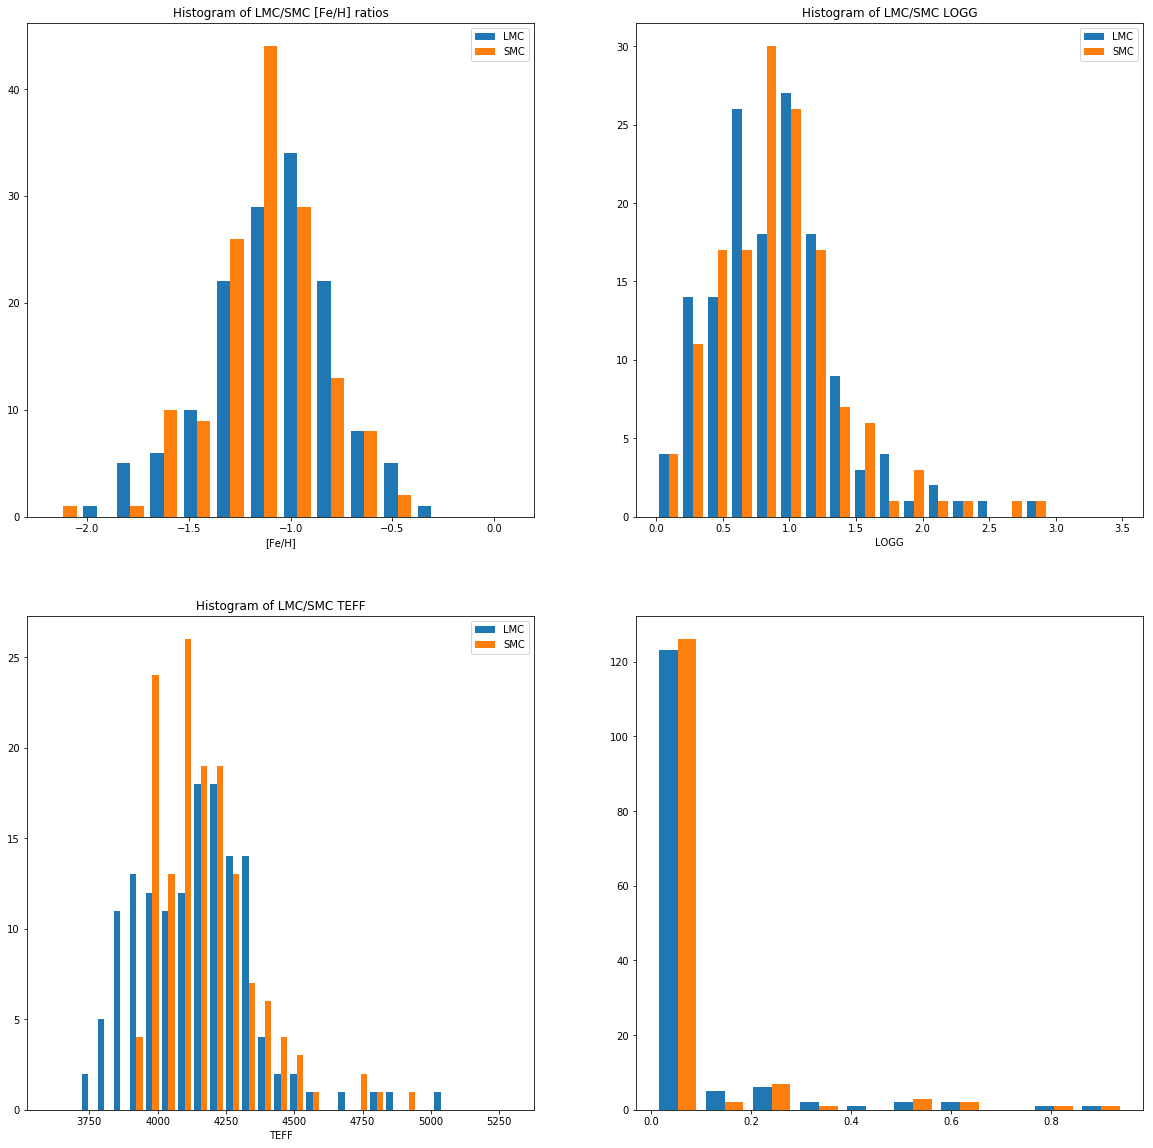

In [136]:
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2,figsize = (20,20))
ax1.hist([AllAvg_LMC['FE_H'], AllAvg_SMC['FE_H']],
         label = ['LMC', 'SMC'],
         bins = np.linspace(-2.2,.1,15))

ax2.hist([AllAvg_LMC['LOGG'], AllAvg_SMC['LOGG']],
          label = ['LMC','SMC'],
          bins = np.linspace(0,3.5,20), align = 'mid')

ax3.hist([AllAvg_LMC['TEFF'], AllAvg_SMC['TEFF']], bins = np.linspace(3600,5300,30), label = ['LMC', 'SMC'])

ax4.hist([AllAvg_LMC['VERR'], AllAvg_SMC['VERR']],  label = ['LMC', 'SMC'],)


ax1.set_title('Histogram of LMC/SMC [Fe/H] ratios')
ax1.set_xlabel('[Fe/H]')
ax1.legend()
ax2.set_title('Histogram of LMC/SMC LOGG')
ax2.set_xlabel('LOGG')
ax2.legend()
ax3.set_title('Histogram of LMC/SMC TEFF')
ax3.set_xlabel('TEFF')
ax3.legend()
plt.show()

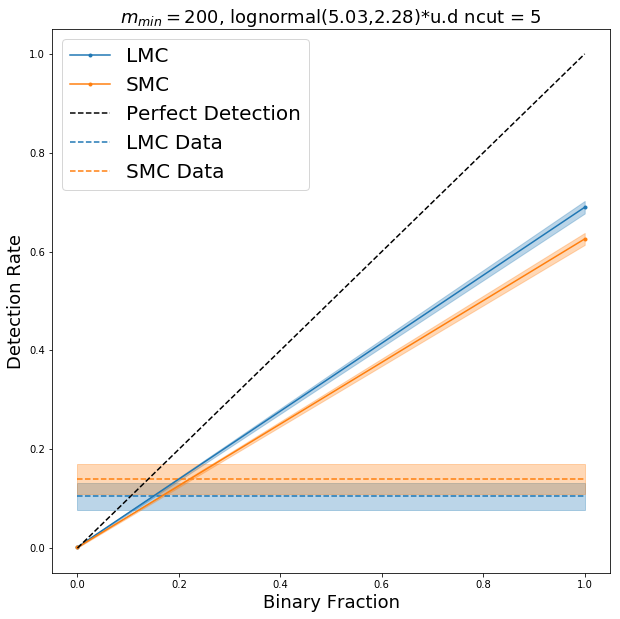

In [134]:
%run Binary_Fraction.py
thing_LMC = Binary_Fraction(AllAvg_LMC)
thing_SMC = Binary_Fraction(AllAvg_SMC)
#real_data = [real_data_detection_LMC_5, binary_bool_LMC_5, LMC_binary_detection_5, rd_err_LMC]
real_data_LMC = thing_LMC.Real_Data_Fraction()
real_data_SMC = thing_SMC.Real_Data_Fraction()

#synthetic_rates = [p_value_result_LMC, binary_result_LMC,  detection_rate_LMC, errors_LMC]
synthetic_rates_LMC = thing_LMC.synthetic_detection_rate(200,'L',True,False,[0,1],30)
synthetic_rates_SMC = thing_SMC.synthetic_detection_rate(200,'L',True,False,[0,1],30)

plt.figure(figsize = (10,10))
b_frac = [0,1]
plt.plot(b_frac, synthetic_rates_LMC[2],'.-', color = 'C0', label = 'LMC')
plt.hlines(real_data_LMC[2], 0 ,1, color = 'C0', linestyles='dashed', label = 'LMC Data')
plt.fill_between([0,1],
                 [synthetic_rates_LMC[3][0][1], synthetic_rates_LMC[3][1][1]],
                 [synthetic_rates_LMC[3][0][0], synthetic_rates_LMC[3][1][0]],
                 alpha = 0.3, color = 'C0')
plt.fill_between([0,1], real_data_LMC[3][0][0], real_data_LMC[3][0][1], alpha = 0.3, color = 'C0')

plt.plot(b_frac, synthetic_rates_SMC[2],'.-', color = 'C1', label = 'SMC')
plt.hlines(real_data_SMC[2], 0 ,1, color = 'C1', linestyles='dashed', label = 'SMC Data')
plt.fill_between([0,1],
                 [synthetic_rates_SMC[3][0][1], synthetic_rates_SMC[3][1][1]],
                 [synthetic_rates_SMC[3][0][0], synthetic_rates_SMC[3][1][0]],
                 alpha = 0.3, color = 'C1')
plt.fill_between([0,1], real_data_SMC[3][0][0], real_data_SMC[3][0][1], alpha = 0.3, color = 'C1')

plt.plot([0,1],[0,1],'--', color = 'black',label = 'Perfect Detection')
plt.xlabel('Binary Fraction', size = 18)
plt.ylabel('Detection Rate', size = 18)
plt.title('$m_{min} = 200$, lognormal(5.03,2.28)*u.d ncut = 5', size = 18)
plt.legend(prop = {'size': 20})
plt.show()

In [126]:
#real_data = [real_data_detection_LMC_5, binary_bool_LMC_5, LMC_binary_detection_5, rd_err_LMC]
#synthetic_rates = [p_value_result_LMC, binary_result_LMC,  detection_rate_LMC, errors_LMC]
epoch_spanLMC = []
for n in range(len(AllAvg_LMC[real_data_LMC[1]])):
    foo = AllAvg_LMC[real_data_LMC[1]]['RADIAL_DATE'][n][-1] - AllAvg_LMC[real_data_LMC[1]]['RADIAL_DATE'][n][0]
    epoch_spanLMC.append(foo)
    
epoch_spanLMC_all = []
for n in range(len(AllAvg_LMC)):
    foo = AllAvg_LMC['RADIAL_DATE'][n][-1] - AllAvg_LMC['RADIAL_DATE'][n][0]
    epoch_spanLMC_all.append(foo)
    
epoch_spanSMC = []
for n in range(len(AllAvg_SMC[real_data_SMC[1]])):
    foo = AllAvg_SMC[real_data_SMC[1]]['RADIAL_DATE'][n][-1] - AllAvg_SMC[real_data_SMC[1]]['RADIAL_DATE'][n][0]
    epoch_spanSMC.append(foo)
    
epoch_spanSMC_all = []
for n in range(len(AllAvg_SMC)):
    foo = AllAvg_SMC['RADIAL_DATE'][n][-1] - AllAvg_SMC['RADIAL_DATE'][n][0]
    epoch_spanSMC_all.append(foo)

In [ ]:
plt.figure(figsize = (20,8))
plt.title('Histogram of LMC epoch spans that gave detections')
x1 = plt.hist(epoch_spanLMC_all, bins = np.arange(30,140,5), label = 'Total data set')
y1 = plt.hist(epoch_spanLMC,bins = np.arange(30,140,5), alpha = 0.75,label = 'Detection data')
plt.xticks(np.arange(30,140,5))
for i in range(len(np.arange(30,140,5))-1):
    percent = "{0:.2f}".format(y1[0][i]/(x1[0][i]+1e-15)*100)
    plt.text(x1[1][i]+1,x1[0][i]+1,percent)
plt.legend()
plt.show()

plt.figure(figsize = (20,8))
plt.title('Histogram of SMC epoch spans that gave detections')
x2 = plt.hist(epoch_spanSMC_all, bins = np.arange(30,100,5), label = 'Total data set')
y2 = plt.hist(epoch_spanSMC,bins = np.arange(30,140,5), alpha = 0.75, label = 'Detection data')
for i in range(len(np.arange(30,100,5))-1):
    percent = "{0:.2f}".format(y2[0][i]/(x2[0][i]+1e-15)*100)
    plt.text(x2[1][i],x2[0][i]+1,percent)
plt.xticks(np.arange(30,100,5))
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
x = plt.hist(AllAvg_LMC['FE_H'], bins = np.arange(-2.5,0.1,0.1), label = 'Total LMC data set')
y = plt.hist(AllAvg_LMC[real_data_LMC[1]]['FE_H'],bins = np.arange(-2.5,0.1,0.1), label = 'Detection set')
plt.legend()
plt.title('Metalicity distribution for LMC', size = 14)
plt.xlabel('[Fe/H]', size = 14)
foo_list = []
for i in range(len(np.arange(-2.5,0.1,0.1))-1):
    percent = "{0:.2f}".format(y[0][i]/(x[0][i]+1e-15)*100)
    plt.text(x[1][i],x[0][i]+2,percent)
    foo_list.append(y[0][i]/(x[0][i]+1e-15)*100)
plt.show()

plt.figure(figsize=(20,10))
x = plt.hist(AllAvg_SMC['FE_H'], bins = np.arange(-2.5,0.1,0.1), label = 'Total SMC data set')
y = plt.hist(AllAvg_SMC[real_data_SMC[1]]['FE_H'], bins = np.arange(-2.5,0.1,0.1), label = 'Detection from SMC')
plt.xticks(np.arange(-2.5,0.1,0.1))
foo_list2 = []
for i in range(len(np.arange(-2.5,0.1,0.1))-1):
    percent = "{0:.2f}".format(y[0][i]/(x[0][i]+1e-15)*100)
    plt.text(x[1][i],x[0][i]+2,percent)
    foo_list2.append(y[0][i]/(x[0][i]+1e-15)*100)
plt.legend()
plt.title('Metalicity distribution for SMC', size = 14)
plt.xlabel('[Fe/H]', size = 14)
plt.show()

In [ ]:
plt.figure(figsize = (20,10))
plt.plot(x[1][:-1],foo_list,'x--', label =  'LMC')
plt.plot(x[1][:-1],foo_list2,'x--', label = 'SMC')
plt.title('Percentage acceptance rate over metalicity', size = 18)
plt.ylabel('% Acceptance', size = 18)
plt.xlabel('[Fe/H]', size = 18)
plt.legend(prop = {'size': 18})
plt.show()

In [ ]:
plt.hist([AllAvg_LMC['VERR'], AllAvg_SMC['VERR']])